# 패키지 다운로드 & 버전 확인

In [14]:
!nvcc -V
!echo
!gcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Sun Dec 12 04:05:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+=========

In [ ]:
!git clone https://github.com/SwinTransformer/Swin-Transformer-Object-Detection.git
!pip install -r /content/Swin-Transformer-Object-Detection/requirements.txt
!pip install openmim
!mim install mmdet
!pip install tqdm

In [ ]:
!git clone https://github.com/NVIDIA/apex
%cd apex
!pip install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
%cd ..

# 데이터 다운로드 & 오류데이터 수정

In [ ]:
!unzip '/content/drive/MyDrive/input/ocr_ancient.zip' -d /content/data

In [5]:
# 목판본_043_언해류_대학언해_01
# 목판본_043_언해류_대학언해1_01
# 필사본_104_문학류_대명영렬전2_01
# 필사본_104_문학류_대병영렬전2_01
# 필사본_105_문학류_대명영렬전3_01
# 필사본_105_문학류_대병영렬전3_01
import os
from glob import glob
json_list = glob(os.path.join('/content/data/이미지데이터','*')) # derectory
for i in json_list:
    tmp_list = glob(os.path.join(i,'*'))
    for j in tmp_list: # image파일

        if j.split('/')[-1][:-8] != i.split('/')[-1]:
            dir_name = i.split('/')[-1]
            img_number = j.split('/')[-1][-8:]
            os.rename(j, '/content/data/이미지데이터/'+dir_name+'/'+dir_name+img_number)

# 데이터 전처리

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import random

from collections import defaultdict, Counter
import json
from glob import glob


In [4]:
!rm -rf /content/data/image

In [44]:
def make_dataset(mode='train', seg_option=False, just_image=False):

    os.makedirs(f'/content/data/{mode}', exist_ok=True)
    dir_list = glob('/content/data/라벨링데이터/*')

    count = 0

    image_idx = 0
    annotation_idx = 0

    images = [] # images.append({'id':image_idx, 'file_name': jf_name+'/'+jf_name+file_name[-4:]+'.png','width':d['Image_Width'], 'height':d['Image_Height']})
    annotations = [] # annotations.append({'id':annotations_idx, 'image_id':image_idx, 'category_id':0,\
                    # 'bbox':(x,y,w,h), 'area':w*h, 'ignore':0,'iscrowd':0,'segmentation':[]})
    for idx, i in tqdm(enumerate(dir_list)): # directory
        print(idx, i)
        dir_name = i.split('/')[-1]
        json_list = glob(os.path.join(i, '*')) # json파일
        if mode == 'train': ################################################# train, valid 비율설정
            iter = json_list[:int(len(json_list)*0.8)]
        else:
            iter = json_list[int(len(json_list)*0.8):]
        for j in iter:
            with open(j, 'r', encoding='utf-8-sig') as jfile:
                d = json.load(jfile)
                image_name = d['Image_filename']
                image_num = image_name[-4:]
                if d['Image_Char_no'] > 400:
                    continue
                
                image = plt.imread(i.replace('라벨링데이터','이미지데이터')+'/'+dir_name+image_num+'.png') # h, w, c

    #             image = np.zeros((int(d['Image_Height']), int(d['Image_Width']), 3), dtype=int)
                h,w,c = image.shape

                ### ----------------- Min, Max 계산 ----------------- ###
                min_y, max_y, min_x, max_x = 1e9, 0, 1e9, 0
                for k in d['Text_Coord']:
                    bbox = k['bbox'] # x,y,w,h
                    min_y, max_y, min_x, max_x = min(min_y, bbox[1]), max(max_y,bbox[1]+bbox[3]),\
                                                min(min_x, bbox[0]), max(max_x,bbox[0]+bbox[2])
                # 자를 지점 결과
                mini_y, maxi_y, mini_x, maxi_x = max(0,min_y-32), min(h,max_y+32), max(0,min_x-32), min(w, max_x+32)
                
                ### ----------------- 글 주변만 자른 이미지 ----------------- ###
                result = image[mini_y:maxi_y, mini_x:maxi_x,:]
                h_, w_, c_ = result.shape
                
                ### ----------------- 가운데를 자르기 전 빈 공간이 있는지 체크 ----------------- ###
                width_check = np.array([0]*w_)

                for k in d['Text_Coord']:
                    bbox = k['bbox']
                    annotate = k['annotate']
                    width_check[bbox[0]-mini_x:bbox[0]-mini_x+bbox[2]] += 1
                
                ### ----------------- 빈 공간이 있으면 이미지 분할 ----------------- ###
                cutting = None
                start = None # 빈공간의 처음지점
                end = None # 빈공간의 마지막 지점 --> 치우치지 않게 자르기 위함
                flag = False
                if h_/w_ < 1.0:
                    for n in range(10, -25,-1):
                        if width_check[w_//2 + n] == 0 and flag == False:
                            start = w_//2 + n
                            end = w_//2 + n
                            flag = True
                        elif width_check[w_//2 + n] == 0 and flag == True:
                            end = w_//2 + n
                        elif width_check[w_//2 + n] != 0 and flag == True:
                            end = w_//2 + n
                            break
                        else:
                            continue
                    if start is None or end is None: # 가로가 긴데 못자르면 패스
                        continue
                        
                    cutting = (start+end)//2
                    
                    left_coord = []
                    right_coord = []
                    
                    for k in d['Text_Coord']:
                        bbox = k['bbox']
                        bbox_ = [bbox[0]-mini_x,bbox[1]-mini_y,bbox[2],bbox[3]] # 원래 bbox에서 여백제거한만큼 이동
                        if bbox_[0] > cutting:
                            bbox_[0] -= cutting
                            right_coord.append(bbox_)
                        else:
                            left_coord.append(bbox_)
                    
                    image_left = result[:,:cutting,:]
                    image_right = result[:,cutting:,:]
                    
                    h_left, w_left, _ = image_left.shape
                    h_right, w_right, _ = image_right.shape
                    if 2 > h_left / w_left >= 1: # 자른 후 세로가 길어야 저장
                        plt.imsave(f'/content/data/{mode}/{image_idx:05d}.png', image_left)
                        if just_image == True:
                            image_idx += 1
                            continue
                        images.append({'id':image_idx, 'file_name': f'{image_idx:05d}.png',\
                                    'width':w_left, 'height':h_left})
                        for ann in left_coord:
                            if 0 > ann[0] or ann[0]+ann[2] > w_left or 0 > ann[1] or ann[1]+ann[3] > h_left:
                                continue
                            seg = None
                            if seg_option:
                                x,y,w,h = ann[:4]
                                box = image_left[y:y+h,x:x+w,:]
                                rgb_distance = (box[:,:,0] - box[:,:,1]) + (box[:,:,0] - box[:,:,1]) + (box[:,:,0] - box[:,:,1])
                                rgb_mask = np.zeros((h,w))
                                for m in np.argwhere(rgb_distance < 0.5):
                                    rgb_mask[m[0], m[1]] = 1
                                
                                box_gray = np.mean(box, axis=2)
                                mean_box = np.mean(box.flatten())
                                under_mean = np.argwhere(box_gray < mean_box*0.9)
                                mean_mask = np.zeros((h,w))
                                for m in under_mean:
                                    mean_mask[m[0],m[1]] = 1
                                total_mask = rgb_mask * mean_mask
                                seg = np.flip(np.argwhere(total_mask==1),axis=1) + [x,y]
                            if seg is None:
                                annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                        'bbox':(ann[0],ann[1],ann[2],ann[3]), 'area':ann[2]*ann[3], 'ignore':0,'iscrowd':0,'segmentation':[]})
                            else:
                                annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                        'bbox':(ann[0],ann[1],ann[2],ann[3]), 'area':ann[2]*ann[3], 'ignore':0,'iscrowd':0,'segmentation':[seg.flatten().tolist()]})
                            annotation_idx += 1
                        image_idx += 1
                    if 2 > h_right / w_right >= 1:
                        plt.imsave(f'/content/data/{mode}/{image_idx:05d}.png', image_right)
                        if just_image == True:
                            image_idx += 1
                            continue
                        images.append({'id':image_idx, 'file_name': f'{image_idx:05d}.png',\
                                    'width':w_right, 'height':h_right})
                        for ann in right_coord:
                            if 0 > ann[0] or ann[0]+ann[2] > w_left or 0 > ann[1] or ann[1]+ann[3] > h_left:
                                continue
                            seg = None
                            if seg_option:
                                x,y,w,h = ann[:4]
                                box = image_right[y:y+h,x:x+w,:]
                                rgb_distance = (box[:,:,0] - box[:,:,1]) + (box[:,:,0] - box[:,:,1]) + (box[:,:,0] - box[:,:,1])
                                rgb_mask = np.zeros((h,w))
                                for m in np.argwhere(rgb_distance < 0.5):
                                    rgb_mask[m[0], m[1]] = 1
                                
                                box_gray = np.mean(box, axis=2)
                                mean_box = np.mean(box.flatten())
                                under_mean = np.argwhere(box_gray < mean_box*0.9)
                                mean_mask = np.zeros((h,w))
                                for m in under_mean:
                                    mean_mask[m[0],m[1]] = 1
                                total_mask = rgb_mask * mean_mask
                                seg = np.flip(np.argwhere(total_mask==1), axis=1) + [x,y]
                            if seg is None:
                                annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                        'bbox':(ann[0],ann[1],ann[2],ann[3]), 'area':ann[2]*ann[3], 'ignore':0,'iscrowd':0,'segmentation':[]})
                            else:
                                annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                        'bbox':(ann[0],ann[1],ann[2],ann[3]), 'area':ann[2]*ann[3], 'ignore':0,'iscrowd':0,'segmentation':[seg.flatten().tolist()]})
                            annotation_idx += 1

                        image_idx += 1
                        
                    
                else: # 세로가 길면
                    if h_/w_ > 2 or d['Image_Char_no'] > 200:
                        continue
                    plt.imsave(f'/content/data/{mode}/{image_idx:05d}.png', result)
                    if just_image == True:
                        image_idx += 1
                        continue
                    images.append({'id':image_idx, 'file_name': f'{image_idx:05d}.png',\
                                'width':w_, 'height':h_})
                    for ann in d['Text_Coord']:
                        x,y,w,h = ann['bbox'][:4]
                        if 0 > x or x+w > w_ or 0 > y or y+h > h_:
                            continue
                        seg = None
                        if seg_option:
                            box = result[y:y+h,x:x+w,:]
                            rgb_distance = (box[:,:,0] - box[:,:,1]) + (box[:,:,0] - box[:,:,1]) + (box[:,:,0] - box[:,:,1])
                            rgb_mask = np.zeros((h,w))
                            for m in np.argwhere(rgb_distance < 0.5):
                                rgb_mask[m[0], m[1]] = 1
                            
                            box_gray = np.mean(box, axis=2)
                            mean_box = np.mean(box.flatten())
                            under_mean = np.argwhere(box_gray < mean_box*0.9)
                            mean_mask = np.zeros((h,w))
                            for m in under_mean:
                                mean_mask[m[0],m[1]] = 1
                            total_mask = rgb_mask * mean_mask
                            seg = np.flip(np.argwhere(total_mask==1), axis=1) + [x,y]
                        if seg is None:
                            annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                    'bbox':(x-mini_x,y-mini_y,w,h), 'area':w*h, 'ignore':0,'iscrowd':0,'segmentation':[]})
                        else:
                            annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                    'bbox':(x-mini_x,y-mini_y,w,h), 'area':w*h, 'ignore':0,'iscrowd':0,'segmentation':[seg.flatten().tolist()]})
                        annotation_idx += 1
                    image_idx += 1
    return images, annotations

In [45]:
def save_json(images, annotations, mode='train'):
    coco_dict = dict(
        info= dict(
            year=2021, 
            version="1.0", 
            description="OCR", 
            contributor="", 
            url=None, 
            date_created=None
        ), # year, version, description, contributor, url, date_created
        licenses=dict(
            id=0,
            name='CC BY 4.0',
            url=''
        ), # id, name, url
        images=list(), # id, file_name, height, width
        annotations=list(), # id, image_id, category_id, bbox, area, iscrowd
        categories = [
            dict(id=0,
                name='word')
        ] # id, name, supercategory
    )
    coco_dict['images'] = images
    coco_dict['annotations'] = annotations
    coco_dict['categories'] = [{'id':0, 'name':'word','super_category':None}]
    # with open('/content/data/train.json', 'wt', encoding='utf-8') as jfile:
    #     json.dump(coco_dict, jfile)
    with open(f"/content/drive/MyDrive/Colab Notebooks/Computer_Vision/{mode}.json", 'wt', encoding='utf-8') as jfile:
        json.dump(coco_dict, jfile)
        

In [ ]:
images, annotations = make_dataset('train', seg_option=True, just_image=False)
save_json(images, annotations, mode='train')
images, annotations = make_dataset('valid', seg_option=True, just_image=False)
save_json(images, annotations, mode='valid')

0it [00:00, ?it/s]

0 /content/data/라벨링데이터/필사본_461_언간류_순명효황후언간1_01
1 /content/data/라벨링데이터/필사본_093_문학류_벽허담관제언록17_01
2 /content/data/라벨링데이터/필사본_248_문학류_유이양문록44_01
3 /content/data/라벨링데이터/필사본_284_문학류_완월회맹연4_01
4 /content/data/라벨링데이터/필사본_548_언간류_명성황후궁녀언간10_01
5 /content/data/라벨링데이터/필사본_536_언간류_숙명신한첩언간66_01
6 /content/data/라벨링데이터/필사본_340_문학류_완월회맹연60_01
7 /content/data/라벨링데이터/필사본_420_문학류_완월회맹연140_01
8 /content/data/라벨링데이터/필사본_139_문학류_명행정의록4_01
9 /content/data/라벨링데이터/필사본_267_문학류_유이양문록63_01
10 /content/data/라벨링데이터/목판본_054_언해류_시경언해7_01
11 /content/data/라벨링데이터/필사본_082_문학류_벽허담관제언록6_01
12 /content/data/라벨링데이터/필사본_257_문학류_유이양문록53_01
13 /content/data/라벨링데이터/필사본_419_문학류_완월회맹연139_01
14 /content/data/라벨링데이터/필사본_364_문학류_완월회맹연84_01
15 /content/data/라벨링데이터/필사본_294_문학류_완월회맹연14_01
16 /content/data/라벨링데이터/필사본_545_언간류_명성황후궁녀언간7_01
17 /content/data/라벨링데이터/필사본_167_문학류_명행정의록32_01
18 /content/data/라벨링데이터/필사본_172_문학류_명행정의록37_01
19 /content/data/라벨링데이터/필사본_374_문학류_완월회맹연94_01
20 /content/data/라벨링데이터/활자본_001_문학류_춘향전_01
21 /content/data/라

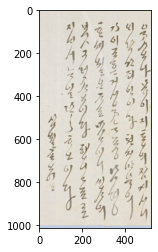

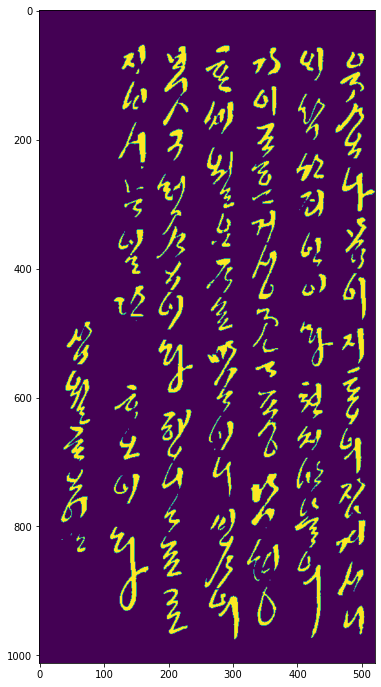

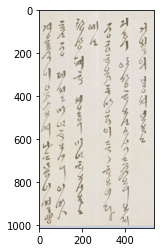

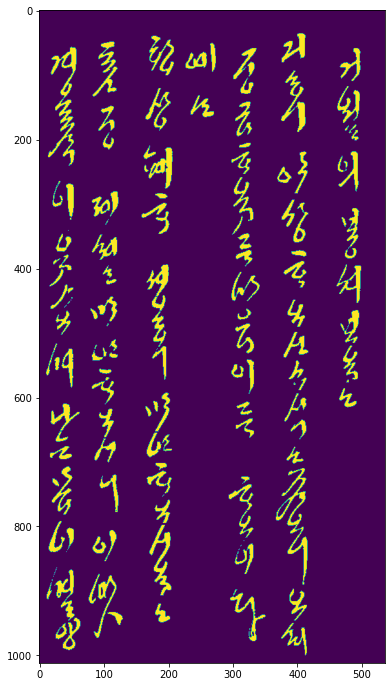

IndexError: ignored

In [43]:
for ff in range(10):
    
    img_ = plt.imread(f'/content/data/train/{images[ff]["file_name"]}')
    plt.imshow(img_)
    plt.show()
    fit, ax = plt.subplots(figsize=(12,12))
    tmp = np.zeros(img_.shape[:2])
    # ax.imshow(img_)


    for i in annotations:
        if i['image_id'] == ff:
            kkk = i['segmentation'][0]
            for j in range(0, len(i['segmentation'][0]), 2):
                tmp[kkk[j+1], kkk[j]] = 1
    ax.imshow(tmp)
    plt.show()
    # plt.imshow(img_)
    # plt.show()

In [9]:
img_ = plt.imread('/content/data/valid/00000.png')

In [ ]:
ann_0 = []
for i in d['annotations']:
    if i['image_id'] == 0:
        ann_0.append(i)
ann_0

In [20]:
len(j['segmentation'])

1

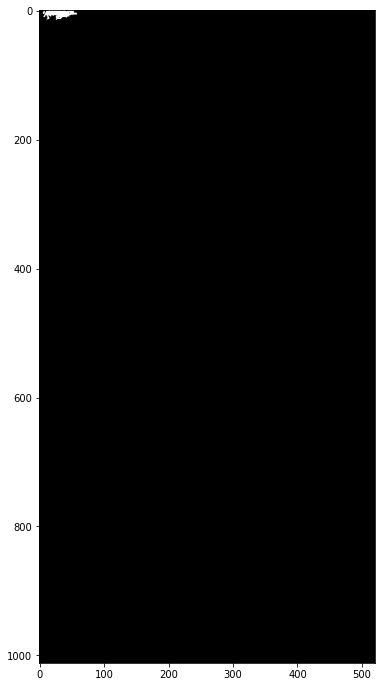

In [21]:
fig,ax = plt.subplots(figsize=(12,12))
# ax.imshow(img_)
tmp = np.zeros(img_.shape[:2])
for j in ann_0:
    x,y,w,h = j['bbox']
    box = img_[y:y+h, x:x+w,:]
    
    for a in range(0, 50, 2):
        tmp[j['segmentation'][0][a], j['segmentation'][0][a+1]] = 1
    rect = patches.Rectangle((x,y),w,h, linewidth=3, edgecolor='r', facecolor='none')
    # ax.add_patch(rect)
plt.imshow(tmp, cmap='gray')
plt.show()
# plt.show()

# MMDetection 학습

In [9]:
%cd Swin-Transformer-Object-Detection/

/content/Swin-Transformer-Object-Detection


In [10]:
import sys
from mmcv import Config
from mmcv.runner import load_checkpoint
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector, set_random_seed, init_detector
from mmdet.datasets import build_dataloader, build_dataset, replace_ImageToTensor
from mmdet.utils import collect_env, get_root_logger

import torch
import time
import json

from pprint import pprint
import os

In [11]:
classes = (
    "word",
)
CUR_PATH = os.getcwd()
# CFG_PATH = "/content/drive/Othercomputers/내 컴퓨터/workspace/ocr_ancient_korean/detection/configs/cascade_rcnn/cascade_rcnn_swin_tiny_fpn_1x_coco.py"
CFG_PATH = "/content/drive/Othercomputers/내 컴퓨터/workspace/ocr_ancient_korean/detection/configs/swin/cascade_mask_rcnn_swin_base_patch4_window7_mstrain_480-800_giou_4conv1f_adamw_3x_coco.py"
PREFIX = "/content/data/image"
WORK_DIR = "/content/drive/MyDrive/Colab Notebooks/Computer_Vision/work_dir"
# CHK_PATH = "/content/drive/MyDrive/Colab Notebooks/lesion_obd/cascade_mask_rcnn_swin_small_patch4_window7.pth"
# config file 들고오기
cfg = Config.fromfile(CFG_PATH)

In [18]:
for i in cfg:
    print(i, '*'*40)
    print(cfg[i])

model ****************************************
{'type': 'CascadeRCNN', 'pretrained': None, 'backbone': {'type': 'SwinTransformer', 'embed_dim': 128, 'depths': [2, 2, 18, 2], 'num_heads': [4, 8, 16, 32], 'window_size': 7, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'drop_rate': 0.0, 'attn_drop_rate': 0.0, 'drop_path_rate': 0.3, 'ape': False, 'patch_norm': True, 'out_indices': (0, 1, 2, 3), 'use_checkpoint': False}, 'neck': {'type': 'FPN', 'in_channels': [128, 256, 512, 1024], 'out_channels': 256, 'num_outs': 5}, 'rpn_head': {'type': 'RPNHead', 'in_channels': 256, 'feat_channels': 256, 'anchor_generator': {'type': 'AnchorGenerator', 'scales': [8], 'ratios': [0.7, 1.0, 2.0], 'strides': [4, 8, 16, 32, 64]}, 'bbox_coder': {'type': 'DeltaXYWHBBoxCoder', 'target_means': [0.0, 0.0, 0.0, 0.0], 'target_stds': [1.0, 1.0, 1.0, 1.0]}, 'loss_cls': {'type': 'CrossEntropyLoss', 'use_sigmoid': True, 'loss_weight': 1.0}, 'loss_bbox': {'type': 'SmoothL1Loss', 'beta': 0.1111111111111111, 'loss_w

In [2]:
with open( '/content/drive/MyDrive/Colab Notebooks/Computer_Vision/valid.json', 'r', encoding='utf-8') as f:
    d = json.load(f)

In [5]:
d['annotations']

Output hidden; open in https://colab.research.google.com to view.

In [12]:

cfg.data.train.classes = classes
cfg.data.train.img_prefix = "/content/data/train"
cfg.data.train.ann_file = '/content/drive/MyDrive/Colab Notebooks/Computer_Vision/train.json'

cfg.data.val.classes = classes
cfg.data.val.img_prefix = "/content/data/valid"
cfg.data.val.ann_file = '/content/drive/MyDrive/Colab Notebooks/Computer_Vision/valid.json'

cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu = 4

cfg.seed = 42
cfg.gpu_ids = [0]

distributed = False

cfg.work_dir = WORK_DIR
cfg.runner.max_epochs = 20
cfg.rtotal_epochs = 20
cfg.optimizer = dict(type='Adam', lr=0.0001, weight_decay=0.0001)

cfg.lr_config = dict(
    policy='CosineAnnealing', # The policy of scheduler, also support CosineAnnealing, Cyclic, etc. Refer to details of supported LrUpdater from https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py#L9.
    by_epoch=False,
    warmup='linear', # The warmup policy, also support `exp` and `constant`.
    warmup_iters=1000, # The number of iterations for warmup
    warmup_ratio=0.001, # The ratio of the starting learning rate used for warmup
    min_lr=1e-07)

cfg.log_config.interval = 600
cfg.checkpoint_config.interval = 1
cfg.log_config = {'hooks': [{'type': 'TextLoggerHook'}], 'interval': 600}
# cfg.model.pretrained = None

model = build_detector(cfg.model)

datasets = [build_dataset(cfg.data.train)]
model.CLASSES = datasets[0].CLASSES

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


loading annotations into memory...
Done (t=172.01s)
creating index...
index created!


In [13]:
train_detector(model, datasets[0], cfg, distributed=distributed, validate=True)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
loading annotations into memory...
Done (t=126.68s)
creating index...
index created!


2021-12-12 04:04:06,888 - mmdet - INFO - Start running, host: root@0344fd22c267, work_dir: /content/drive/MyDrive/Colab Notebooks/Computer_Vision/work_dir
2021-12-12 04:04:06,890 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) CosineAnnealingLrUpdaterHook       
(ABOVE_NORMAL) DistOptimizerHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) CosineAnnealingLrUpdaterHook       
(NORMAL      ) EvalHook                           
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) CosineAnnealingLrUpdaterHook       
(LOW         ) IterTimerHook                      
 -------------------- 
after_train_iter:
(ABOVE_

error: ignored